In [1]:
import os
from pathlib import Path
import numpy as np
from PIL import Image
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, feature, morphology, measure, transform
import skimage.transform

import cv2

In [2]:
# Adaptive threshold levels
BKG_THRESH = 60
CARD_THRESH = 30

# Width and height of card corner, where rank and suit are
CORNER_WIDTH = 32
CORNER_HEIGHT = 84

# Dimensions of rank train images
RANK_WIDTH = 70
RANK_HEIGHT = 125

# Dimensions of suit train images
SUIT_WIDTH = 70
SUIT_HEIGHT = 100

RANK_DIFF_MAX = 2000
SUIT_DIFF_MAX = 700

CARD_MAX_AREA = 120000
CARD_MIN_AREA = 25000

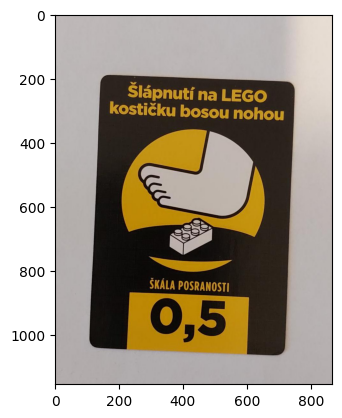

In [3]:
img_path_raw = "/home/silverjoda/SW/st_happens/st_happens/data/raw_imgs"
img_path = os.path.join(img_path_raw, "1.jpg") 

# Read image with cv2
img = cv2.imread(img_path)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Plot image
plt.imshow(img)

In [4]:
def preprocess_image(image):
    """Returns a grayed, blurred, and adaptively thresholded camera image."""

    # Reverse image colors to get black bg
    image = cv2.bitwise_not(image)

    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),0)

    # The best threshold level depends on the ambient lighting conditions.
    # For bright lighting, a high threshold must be used to isolate the cards
    # from the background. For dim lighting, a low threshold must be used.
    # To make the card detector independent of lighting conditions, the
    # following adaptive threshold method is used.
    #
    # A background pixel in the center top of the image is sampled to determine
    # its intensity. The adaptive threshold is set at 50 (THRESH_ADDER) higher
    # than that. This allows the threshold to adapt to the lighting conditions.
    
    img_w, img_h = np.shape(image)[:2]
    bkg_level = gray[int(img_h/100)][int(img_w/2)]
    thresh_level = bkg_level + BKG_THRESH
    
    retval, thresh = cv2.threshold(blur,thresh_level,255,cv2.THRESH_BINARY)
    
    return thresh

img_preproc = preprocess_image(img)

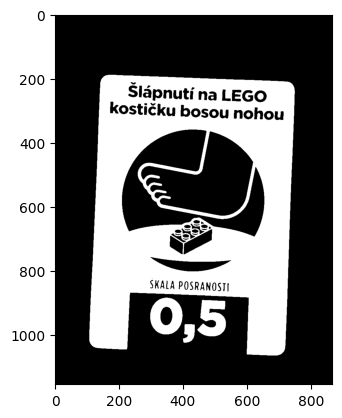

In [5]:
plt.imshow(img_preproc, cmap="gray")

In [6]:
def find_cards(thresh_image):
    """Finds all card-sized contours in a thresholded camera image.
    Returns the number of cards, and a list of card contours sorted
    from largest to smallest."""

    # Find contours and sort their indices by contour size
    cnts,hier = cv2.findContours(thresh_image,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    index_sort = sorted(range(len(cnts)), key=lambda i : cv2.contourArea(cnts[i]),reverse=True)

    # If there are no contours, do nothing
    if len(cnts) == 0:
        return [], []
    
    # Otherwise, initialize empty sorted contour and hierarchy lists
    cnts_sort = []
    hier_sort = []
    cnt_is_card = np.zeros(len(cnts),dtype=int)

    # Fill empty lists with sorted contour and sorted hierarchy. Now,
    # the indices of the contour list still correspond with those of
    # the hierarchy list. The hierarchy array can be used to check if
    # the contours have parents or not.
    for i in index_sort:
        cnts_sort.append(cnts[i])
        hier_sort.append(hier[0][i])

    # Determine which of the contours are cards by applying the
    # following criteria: 1) Smaller area than the maximum card size,
    # 2), bigger area than the minimum card size, 3) have no parents,
    # and 4) have four corners

    for i in range(len(cnts_sort)):
        size = cv2.contourArea(cnts_sort[i])
        peri = cv2.arcLength(cnts_sort[i],True)
        approx = cv2.approxPolyDP(cnts_sort[i],0.01*peri,True)
        
        if ((size < CARD_MAX_AREA) and (size > CARD_MIN_AREA)
            and (hier_sort[i][3] == -1) and (len(approx) == 4)):
            cnt_is_card[i] = 1

    return cnts_sort, cnt_is_card


In [7]:
cnts_sort, cnt_is_card = find_cards(img_preproc)

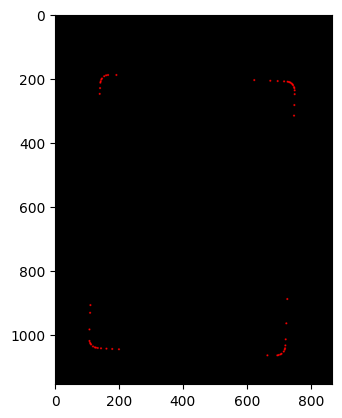

In [8]:
hull = cv2.convexHull(cnts_sort[0], clockwise=True)
img_contours = cv2.drawContours(np.zeros_like(img), hull, -1, (255,0,0), 5)
plt.imshow(img_contours)

# TODO: Why are we getting only a few points in the convex hull?
# TODO: Find out how to do a perspective transform with the points from the convex hull

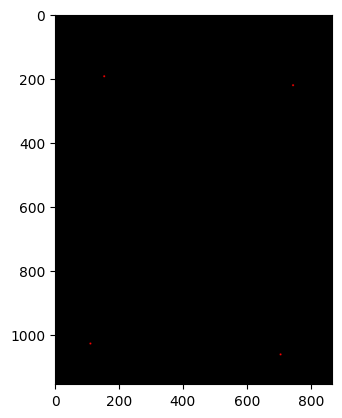

In [13]:
dp_cnt = cv2.approxPolyDP(hull,0.01 * cv2.arcLength(hull, True), True)
img_contours = cv2.drawContours(np.zeros_like(img), dp_cnt, -1, (255,0,0), 5)
plt.imshow(img_contours)

In [14]:
def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    # return the warped image
    return warped

tmp_img = img.copy()
pts = np.array([extLeft, extRight, extTop, extBot])
warped = four_point_transform(tmp_img, pts)

In [16]:
cnt_is_card

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [14]:
for c in cnts_sort:
    print(len(c))

333
860
567
151
161
179
172
72
57
63
60
37
48
77
42
85
40
47
40
44
40
43
43
43
38
50
40
34
37
35
37
40
37
20
68
40
65
33
47
58
55
60
12
24
27
34
14
34
41
12
23
39
30
34
36
24
26
24
21
24
22
35
39
48
19
16
14
21
11
21
20
22
12
10
16
19
18
15
18
17
18
18
14
14
19
18
9
12
15
8
9
12
10
10
9
6
6


In [10]:
len(cnts_sort), len(cnt_is_card)

(97, 97)

In [9]:
def preprocess_card(contour, image):
    """Uses contour to find information about the query card. Isolates rank
    and suit images from the card."""

    # Initialize new Query_card object
    qCard = Query_card()

    qCard.contour = contour

    # Find perimeter of card and use it to approximate corner points
    peri = cv2.arcLength(contour,True)
    approx = cv2.approxPolyDP(contour,0.01*peri,True)
    pts = np.float32(approx)
    qCard.corner_pts = pts

    # Find width and height of card's bounding rectangle
    x,y,w,h = cv2.boundingRect(contour)
    qCard.width, qCard.height = w, h

    # Find center point of card by taking x and y average of the four corners.
    average = np.sum(pts, axis=0)/len(pts)
    cent_x = int(average[0][0])
    cent_y = int(average[0][1])
    qCard.center = [cent_x, cent_y]

    # Warp card into 200x300 flattened image using perspective transform
    qCard.warp = flattener(image, pts, w, h)

    # Grab corner of warped card image and do a 4x zoom
    Qcorner = qCard.warp[0:CORNER_HEIGHT, 0:CORNER_WIDTH]
    Qcorner_zoom = cv2.resize(Qcorner, (0,0), fx=4, fy=4)

    # Sample known white pixel intensity to determine good threshold level
    white_level = Qcorner_zoom[15,int((CORNER_WIDTH*4)/2)]
    thresh_level = white_level - CARD_THRESH
    if (thresh_level <= 0):
        thresh_level = 1
    retval, query_thresh = cv2.threshold(Qcorner_zoom, thresh_level, 255, cv2. THRESH_BINARY_INV)
    
    # Split in to top and bottom half (top shows rank, bottom shows suit)
    Qrank = query_thresh[20:185, 0:128]
    Qsuit = query_thresh[186:336, 0:128]

    # Find rank contour and bounding rectangle, isolate and find largest contour
    dummy, Qrank_cnts, hier = cv2.findContours(Qrank, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    Qrank_cnts = sorted(Qrank_cnts, key=cv2.contourArea,reverse=True)

    # Find bounding rectangle for largest contour, use it to resize query rank
    # image to match dimensions of the train rank image
    if len(Qrank_cnts) != 0:
        x1,y1,w1,h1 = cv2.boundingRect(Qrank_cnts[0])
        Qrank_roi = Qrank[y1:y1+h1, x1:x1+w1]
        Qrank_sized = cv2.resize(Qrank_roi, (RANK_WIDTH,RANK_HEIGHT), 0, 0)
        qCard.rank_img = Qrank_sized

    # Find suit contour and bounding rectangle, isolate and find largest contour
    dummy, Qsuit_cnts, hier = cv2.findContours(Qsuit, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    Qsuit_cnts = sorted(Qsuit_cnts, key=cv2.contourArea,reverse=True)
    
    # Find bounding rectangle for largest contour, use it to resize query suit
    # image to match dimensions of the train suit image
    if len(Qsuit_cnts) != 0:
        x2,y2,w2,h2 = cv2.boundingRect(Qsuit_cnts[0])
        Qsuit_roi = Qsuit[y2:y2+h2, x2:x2+w2]
        Qsuit_sized = cv2.resize(Qsuit_roi, (SUIT_WIDTH, SUIT_HEIGHT), 0, 0)
        qCard.suit_img = Qsuit_sized

    return qCard

preprocess_card(cnts_sort[0],img)

NameError: name 'Query_card' is not defined